### RBF KAN model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import einops
import math 

def radial_basis_function(x, grid_pnts, widths):
    """_summary_

    Args:
        x (_type_): _description_
        grid_pnts (_type_): _description_
        widths (_type_): _description_

    Returns:
        _type_: _description_
    """
    # Calculate the squared Euclidean distance between x and each center
    activations = torch.exp( - ((x - grid_pnts) / widths) ** 2)
    return activations


class RBFLayer(nn.Module):
    def __init__(self, width=None,
                 grid_min=-2.0, grid_max=2.0, grid_size=10, 
                 trainable_center=False,
                 trainable_width=False):
        super(RBFLayer, self).__init__()
        grid = torch.linspace(grid_min, grid_max, grid_size)
        self.centers = nn.Parameter(grid, requires_grad=trainable_center)
        if width is None:
            width = (grid_max - grid_min) / (grid_size - 1)
        self.width = nn.Parameter(torch.tensor(width, dtype=torch.float32), requires_grad=trainable_width)

    def forward(self, x):
        activations = torch.exp( - ((x[..., None] - self.centers) / self.width)**2)
        return activations


class RBFKANLayer(nn.Module):
    def __init__(self, 
                 input_dim : int, 
                 output_dim : int,
                 residual=True,
                 grid_min=-2.0, grid_max=2.0, grid_size=10, width=None,
                 trainable_center=False,
                 trainable_width=False):
        super(RBFKANLayer, self).__init__()
        self.rbf = RBFLayer(width, grid_min, grid_max, grid_size, trainable_center, trainable_width)
        basis_coef = torch.randn(input_dim, grid_size) / math.sqrt(input_dim)
        self.basis_coef = nn.Parameter(basis_coef, requires_grad=True)
        self.residual = residual
        if residual:
            self.res_act = nn.SiLU()
        self.readout = nn.Linear(input_dim, output_dim)
        # self.basis_combined = nn.Linear(input_dim * grid_size, output_dim)
        

    def forward(self, x):
        rbf_act = self.rbf(x) # [batch_size, input_dim, grid_size]
        rbf_act = einops.einsum(rbf_act, self.basis_coef, 'B inp grid, inp grid -> B inp')
        if self.residual:
            rbf_act = rbf_act + self.res_act(x)
        out = self.readout(rbf_act)
        return out
        

class RBFKANnet(nn.Module):
    def __init__(self, layer_dim_list, residual=True, KAN_config=None):
        super(RBFKANnet, self).__init__()
        self.layers = nn.ModuleList()
        if KAN_config is None:
            KAN_config = {'grid_min': -2.0, 'grid_max': 2.0, 'grid_size': 10, 'width': None,
                          'trainable_center': False, 'trainable_width': False}
        for i in range(len(layer_dim_list) - 1):
            self.layers.append(RBFKANLayer(layer_dim_list[i], layer_dim_list[i+1], 
                                           residual=residual, **KAN_config))
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


### Graph model

In [2]:
import torch
import torch.nn as nn
import networkx as nx

class GraphModel(nn.Module):
    """This version only allows input at the leaf node like a computational graph"""
    def __init__(self, graph, input_nodes, output_nodes):
        """
        Initializes the GraphModel.

        Args:
            graph (networkx.DiGraph): A directed acyclic graph where each node has a 'func' attribute.
            input_nodes (list): List of node names that serve as inputs.
            output_nodes (list): List of node names whose outputs are considered as the model's output.
        """
        super(GraphModel, self).__init__()
        self.graph = graph
        self.input_nodes = input_nodes
        self.output_nodes = output_nodes

        # Ensure the graph is a DAG
        if not nx.is_directed_acyclic_graph(self.graph):
            raise ValueError("The graph must be a Directed Acyclic Graph (DAG).")

        # Determine processing order
        self.topo_order = list(nx.topological_sort(self.graph))

    def forward(self, input_tensor_dict, verbose=False):
        """
        Forward pass of the GraphModel.

        Args:
            input_tensor_dict (dict): A dictionary mapping input node names to input tensors.

        Returns:
            torch.Tensor: The combined output from the specified output nodes.
        """
        batch = next(iter(input_tensor_dict.values())).shape
        dtype = next(iter(input_tensor_dict.values())).dtype
        device = next(iter(input_tensor_dict.values())).device
        node_outputs = {}

        for node in self.topo_order:
            func = self.graph.nodes[node].get('func', None)

            if node in self.input_nodes:
                # Input nodes receive external input
                if node not in input_tensor_dict:
                    raise ValueError(f"Input for node '{node}' not provided.")
                node_outputs[node] = func(input_tensor_dict[node])
                if verbose:
                    print(f"Node '{node}' is an input node. Output: {node_outputs[node][0].detach()}") # :.4f}
            else:
                # Non-input nodes sum outputs from all parent nodes
                parents = list(self.graph.predecessors(node))
                if not parents:
                    # raise ValueError(f"Node '{node}' has no parents and is not an input node.")
                    node_output = torch.zeros(batch, dtype=dtype, device=device) # TODO: check if this is correct
                else:
                    # Sum outputs from all parents
                    sum_parents = torch.zeros(batch, dtype=dtype, device=device)# TODO: check if this is correct
                    for parent in parents:
                        sum_parents += node_outputs[parent]
                    # Apply the node's function
                    node_output = func(sum_parents)
                    if verbose:
                        print(f"Node '{node}': sum of parents = {sum_parents[0].detach()}, applying {func.__name__}({sum_parents[0].detach()}) = {node_output[0].detach()}")
                node_outputs[node] = node_output

        # Combine outputs from output_nodes (e.g., sum or concatenate)
        # Here, we'll sum the outputs
        final_output = torch.zeros_like(next(iter(node_outputs.values())))
        for out_node in self.output_nodes:
            final_output += node_outputs[out_node]
        if verbose:
            print(f"Final Output: {final_output[0].detach()}")
        return final_output

In [41]:
import torch
import torch.nn as nn
import networkx as nx

class GraphModel_Syn(nn.Module):
    """This version allows input onto any node, which will be summed up to the parent output"""
    def __init__(self, graph, input_nodes, output_nodes):
        """
        Initializes the GraphModel.

        Args:
            graph (networkx.DiGraph): A directed acyclic graph where each node has a 'func' attribute.
            input_nodes (list): List of node names that serve as inputs.
            output_nodes (list): List of node names whose outputs are considered as the model's output.
        """
        super(GraphModel_Syn, self).__init__()
        self.graph = graph
        self.input_nodes = input_nodes
        self.output_nodes = output_nodes
        self.node_modules = nn.ModuleList()
        for node in self.graph.nodes:
            if 'func' in self.graph.nodes[node]:
                self.node_modules.append(self.graph.nodes[node]['func'])
        # Ensure the graph is a DAG
        if not nx.is_directed_acyclic_graph(self.graph):
            raise ValueError("The graph must be a Directed Acyclic Graph (DAG).")

        # Determine processing order
        self.topo_order = list(nx.topological_sort(self.graph))

    def forward(self, input_tensor_dict, verbose=False):
        """
        Forward pass of the GraphModel.

        Args:
            input_tensor_dict (dict): A dictionary mapping input node names to input tensors.

        Returns:
            torch.Tensor: The combined output from the specified output nodes.
        """
        batch = next(iter(input_tensor_dict.values())).shape
        dtype = next(iter(input_tensor_dict.values())).dtype
        device = next(iter(input_tensor_dict.values())).device
        node_outputs = {}

        for node in self.topo_order:
            func = self.graph.nodes[node].get('func', None)
            
            parents = list(self.graph.predecessors(node))
            if (not parents) and (node not in self.input_nodes):
                # f"Node '{node}' has no parents and is not an input node."
                node_output = torch.zeros(batch, dtype=dtype, device=device) # TODO: check if this is correct
            else:
                # Sum outputs from all parents
                sum_parents = torch.zeros(batch, dtype=dtype, device=device)
                if node in self.input_nodes:
                    # Input nodes receive external input
                    if node in input_tensor_dict:
                        sum_parents += input_tensor_dict[node]
                        if verbose:
                            print(f"Node '{node}' is an input node. Input: {input_tensor_dict[node][0].detach()}") 
                    else:
                        # raise ValueError(f"Input for node '{node}' not provided.")
                        pass
                # Non-input nodes sum outputs from all parent nodes
                # Sum outputs from all parents
                for parent in parents:
                    sum_parents += node_outputs[parent]
                # Apply the node's function
                node_output = func(sum_parents)
                if verbose:
                    print(f"Node '{node}': sum of parents = {sum_parents[0].detach()}, applying {func.__name__}({sum_parents[0].detach()}) = {node_output[0].detach()}")
            node_outputs[node] = node_output

        # Combine outputs from output_nodes (e.g., sum or concatenate)
        # Here, we'll sum the outputs
        final_output = torch.zeros_like(next(iter(node_outputs.values())))
        for out_node in self.output_nodes:
            final_output += node_outputs[out_node]
        if verbose:
            print(f"Final Output: {final_output[0].detach()}")
        return final_output

### Custom toy graphs

In [8]:
def create_sample_graph():
    G = nx.DiGraph()

    # Define nodes with their respective functions
    # Input nodes use the identity function (no processing)
    G.add_node('input1', func=lambda x: x)
    G.add_node('input2', func=lambda x: x)

    # Intermediate nodes apply various torch functions
    G.add_node('node1', func=torch.sin)
    G.add_node('node2', func=torch.cos)
    G.add_node('node3', func=torch.tanh)

    # Output node applies sigmoid
    G.add_node('output', func=torch.sigmoid)

    # Define edges (dependencies)
    G.add_edge('input1', 'node1')
    G.add_edge('input2', 'node1')
    G.add_edge('input1', 'node2')
    G.add_edge('node1', 'node3')
    G.add_edge('node2', 'node3')
    G.add_edge('node3', 'output')

    return G

In [9]:
# Create the sample graph
graph = create_sample_graph()
# Define input and output nodes
input_nodes = ['input1', 'input2']
output_nodes = ['output']
# Instantiate the model
model = GraphModel(graph, input_nodes, output_nodes)
# Define input tensors
input_tensor_dict = {
    'input1': torch.tensor(0.5),
    'input2': torch.tensor(0.3)
}
# Perform a forward pass
output = model(input_tensor_dict)

In [10]:
graph.nodes['input1']['func'](torch.tensor(0.0))

tensor(0.)

In [11]:
def create_complex_graph():
    G = nx.DiGraph()

    # Input nodes
    G.add_node('input1', func=lambda x: x)
    G.add_node('input2', func=lambda x: x)
    G.add_node('input3', func=lambda x: x)

    # Intermediate nodes
    G.add_node('node1', func=torch.relu)
    G.add_node('node2', func=torch.sigmoid)
    G.add_node('node3', func=torch.tanh)
    G.add_node('node4', func=torch.sin)

    # Output node
    G.add_node('output', func=torch.cos)

    # Define edges
    G.add_edge('input1', 'node1')
    G.add_edge('input2', 'node1')
    G.add_edge('input1', 'node2')
    G.add_edge('input3', 'node2')
    G.add_edge('node1', 'node3')
    G.add_edge('node2', 'node3')
    G.add_edge('node3', 'node4')
    G.add_edge('node4', 'output')

    return G

# if __name__ == "__main__":
# Create the complex graph
complex_graph = create_complex_graph()

# Define input and output nodes
input_nodes = ['input1', 'input2', 'input3']
output_nodes = ['output']

# Instantiate the model
complex_model = GraphModel(complex_graph, input_nodes, output_nodes)

# Define input tensors
input_tensor_dict = {
    'input1': torch.tensor(0.7),
    'input2': torch.tensor(-0.2),
    'input3': torch.tensor(0.5)
}

# Perform a forward pass
output = complex_model(input_tensor_dict)

### Create binary tree structure 

In [12]:
import networkx as nx
import matplotlib.pyplot as plt

def create_binary_tree_builtin(depth=3):
    """
    Creates a binary tree graph using NetworkX's built-in balanced_tree function.

    Args:
        depth (int): The depth of the binary tree.

    Returns:
        networkx.DiGraph: A directed graph representing the binary tree.
    """
    # Create a balanced binary tree with branching factor 2 and specified depth
    # The total number of nodes will be 2^depth - 1
    G = nx.balanced_tree(r=2, h=depth-1, create_using=nx.DiGraph())
    G_reversed = nx.DiGraph()

    # Add reversed edges
    for u, v in G.edges():
        G_reversed.add_edge(v, u)

    return G_reversed


In [13]:
G = create_binary_tree_builtin(depth=4)

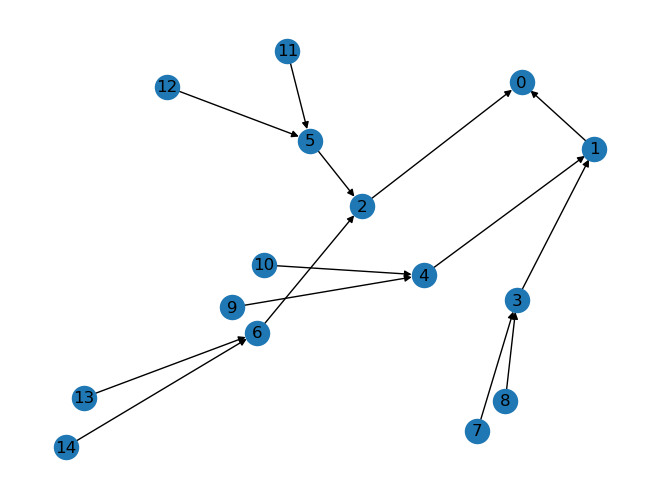

In [14]:
# Visualize the graph, otherlayout?
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=False)
nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes});

### Add functions on nodes

In [15]:
import torch

def assign_random_functions_to_binary_tree(G, ):
    """
    Assigns PyTorch functions to each node in the binary tree based on their depth.

    Args:
        G (networkx.DiGraph): The binary tree graph.
        depth (int): The depth of the binary tree.

    Returns:
        None: Modifies the graph in place by adding 'func' attribute to each node.
    """
    # Determine the depth of each node using BFS
    root = 0 if not G.nodes() else min(G.nodes())  # Assuming the smallest node is the root
    depths = {root: 0}
    queue = [root]
    
    while queue:
        current = queue.pop(0)
        current_depth = depths[current]
        for child in G.predecessors(current):
            depths[child] = current_depth + 1
            queue.append(child)
    
    max_depth = max(depths.values())
    
    # Assign functions based on depth
    for node in G.nodes():
        node_depth = depths[node]
        if node_depth == max_depth:
            G.nodes[node]['func'] = torch.sin
        elif node_depth == max_depth - 1:
            G.nodes[node]['func'] = torch.cos
        elif node_depth == 0:
            G.nodes[node]['func'] = torch.relu
        else:
            # For deeper trees, assign other functions or reuse
            G.nodes[node]['func'] = torch.tanh

In [42]:
assign_random_functions_to_binary_tree(G, )
Gnet = GraphModel(G, input_nodes=[7, 8, 9, 10, 11, 12, 13, 14], output_nodes=[0])
batch = 5
input_tensor_dict = {
    7: torch.randn(batch),
    8: torch.randn(batch),
    9: torch.randn(batch),
    10: torch.randn(batch),
    11: torch.randn(batch),
    12: torch.randn(batch),
    13: torch.randn(batch),
    14: torch.randn(batch),
}
Gnet(input_tensor_dict)

tensor([1.7663, 1.7928, 1.3149, 1.4061, 1.8928])

In [43]:
batch = 5
G = create_binary_tree_builtin(depth=6)
assign_random_functions_to_binary_tree(G, ) # use the KAN node at this step
Gnet = GraphModel(G, input_nodes=[7, 8, 9, 10, 11, ], output_nodes=[0])
input_tensor_dict = {
    7: torch.randn(batch),
    8: torch.randn(batch),
    9: torch.randn(batch),
    10: torch.randn(batch),
    11: torch.randn(batch),
}
Gnet(input_tensor_dict, verbose=True)

Node '15': sum of parents = 0.0, applying cos(0.0) = 1.0
Node '16': sum of parents = 0.0, applying cos(0.0) = 1.0
Node '17': sum of parents = 0.0, applying cos(0.0) = 1.0
Node '18': sum of parents = 0.0, applying cos(0.0) = 1.0
Node '19': sum of parents = 0.0, applying cos(0.0) = 1.0
Node '20': sum of parents = 0.0, applying cos(0.0) = 1.0
Node '21': sum of parents = 0.0, applying cos(0.0) = 1.0
Node '22': sum of parents = 0.0, applying cos(0.0) = 1.0
Node '23': sum of parents = 0.0, applying cos(0.0) = 1.0
Node '24': sum of parents = 0.0, applying cos(0.0) = 1.0
Node '25': sum of parents = 0.0, applying cos(0.0) = 1.0
Node '26': sum of parents = 0.0, applying cos(0.0) = 1.0
Node '27': sum of parents = 0.0, applying cos(0.0) = 1.0
Node '28': sum of parents = 0.0, applying cos(0.0) = 1.0
Node '29': sum of parents = 0.0, applying cos(0.0) = 1.0
Node '30': sum of parents = 0.0, applying cos(0.0) = 1.0
Node '7' is an input node. Output: 0.12586985528469086
Node '8' is an input node. Output

tensor([0.4920, 0.7308, 1.0835, 0.0221, 0.3719])

### Assign KAN functions to nodes on a binary tree

In [44]:
import torch

def assign_KANnode_functions_to_binary_tree(G, KANconstructor):
    """
    Assigns PyTorch functions to each node in the binary tree based on their depth.

    Args:
        G (networkx.DiGraph): The binary tree graph.
        depth (int): The depth of the binary tree.

    Returns:
        None: Modifies the graph in place by adding 'func' attribute to each node.
    """
    # Determine the depth of each node using BFS
    root = 0 if not G.nodes() else min(G.nodes())  # Assuming the smallest node is the root
    depths = {root: 0}
    queue = [root]
    
    while queue:
        current = queue.pop(0)
        current_depth = depths[current]
        for child in G.predecessors(current):
            depths[child] = current_depth + 1
            queue.append(child)
    
    max_depth = max(depths.values())
    
    # Assign functions based on depth
    for node in G.nodes():
        # node_depth = depths[node]
        G.nodes[node]['func'] = KANconstructor()

In [45]:
def KANconstructor():
    module = RBFKANLayer(1, 1)
    module.__name__ = 'RBFKANnet'
    return module

In [46]:
batch = (2048, 1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
G = create_binary_tree_builtin(depth=4)
assign_KANnode_functions_to_binary_tree(G, KANconstructor)
Gnet = GraphModel_Syn(G, input_nodes=[2, 5, 11, 15], output_nodes=[0])
input_tensor_dict = {
    2: torch.randn(batch).to(device),
    5: torch.randn(batch).to(device),
    11: torch.randn(batch).to(device),
    15: torch.randn(batch).to(device),
}
Gnet.to(device)
Gnet(input_tensor_dict, verbose=True);

Node '11' is an input node. Input: tensor([1.0116], device='cuda:0')
Node '11': sum of parents = tensor([1.0116], device='cuda:0'), applying RBFKANnet(tensor([1.0116], device='cuda:0')) = tensor([-0.9033], device='cuda:0')
Node '3': sum of parents = tensor([0.], device='cuda:0'), applying RBFKANnet(tensor([0.], device='cuda:0')) = tensor([1.0826], device='cuda:0')
Node '4': sum of parents = tensor([0.], device='cuda:0'), applying RBFKANnet(tensor([0.], device='cuda:0')) = tensor([0.4265], device='cuda:0')
Node '5' is an input node. Input: tensor([0.0080], device='cuda:0')
Node '5': sum of parents = tensor([-0.8953], device='cuda:0'), applying RBFKANnet(tensor([-0.8953], device='cuda:0')) = tensor([0.3846], device='cuda:0')
Node '6': sum of parents = tensor([0.], device='cuda:0'), applying RBFKANnet(tensor([0.], device='cuda:0')) = tensor([-1.9545], device='cuda:0')
Node '1': sum of parents = tensor([1.5091], device='cuda:0'), applying RBFKANnet(tensor([1.5091], device='cuda:0')) = tens

In [60]:
import torch
from torch.utils.data import TensorDataset, DataLoader
# Set random seed for reproducibility
torch.manual_seed(42)
# Define the function f with 5 variables
def f(x):
    """
    Example function that takes a tensor x of shape (..., 5) and returns a tensor y.
    You can customize this function as needed.
    """
    # Example: y = sin(x1) + x2^2 - log(|x3| + 1) + exp(x4) - sqrt(|x5|)
    # To ensure numerical stability, we handle absolute values and add 1 where necessary.
    y = (
        torch.sin(x[:, 0]) +
        torch.pow(x[:, 1], 2) -
        torch.log(torch.abs(x[:, 2]) + 1) +
        torch.exp(x[:, 3]) -
        torch.sqrt(torch.abs(x[:, 4]))
    )
    return y
# Number of samples
num_samples = 5000
# Generate random input data in the range [-2, 2] for each of the 5 variables
Xtsr = torch.empty(num_samples, 5).uniform_(-2, 2)
# Compute the corresponding outputs
y = f(Xtsr).unsqueeze(1)  # Make y a column tensor

# Create a TensorDataset
# dataset = TensorDataset(Xtsr, y)
Xtsr = Xtsr.to(device)
y = y.to(device)
# split train and test
Xtsr_train, Xtsr_val = Xtsr[:4000], Xtsr[4000:]
y_train, y_val = y[:4000], y[4000:]
input_tensor_dict = {
    11: Xtsr_train[:, 0:1],
    12: Xtsr_train[:, 1:2],
    13: Xtsr_train[:, 2:3],
    14: Xtsr_train[:, 3:4],
    15: Xtsr_train[:, 4:5],
}
val_tensor_dict = {
    11: Xtsr_val[:, 0:1],
    12: Xtsr_val[:, 1:2],
    13: Xtsr_val[:, 2:3],
    14: Xtsr_val[:, 3:4],
    15: Xtsr_val[:, 4:5],
}
G = create_binary_tree_builtin(depth=4)
assign_KANnode_functions_to_binary_tree(G, KANconstructor)
Gnet = GraphModel_Syn(G, input_nodes=[11,12,13,14,15], output_nodes=[0])
Gnet.to(device).train()
# Define the loss function
loss_fn = torch.nn.MSELoss()
max_epoch = 5000
# Define the optimizer
optimizer = torch.optim.Adam(Gnet.parameters(), lr=0.005)
for epoch in range(max_epoch):
    # Forward pass
    y_pred = Gnet(input_tensor_dict)
    loss = loss_fn(y_pred, y_train)
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
        with torch.no_grad():
            y_val_pred = Gnet(val_tensor_dict)
            val_loss = loss_fn(y_val_pred, y_val)
            print(f"Validation Loss: {val_loss.item():.4f}")

Epoch 0, Loss: 5.9013
Validation Loss: 6.3123
Epoch 100, Loss: 3.1808
Validation Loss: 3.1929
Epoch 200, Loss: 2.0337
Validation Loss: 2.0780
Epoch 300, Loss: 0.6906
Validation Loss: 0.6532
Epoch 400, Loss: 0.4023
Validation Loss: 0.3607
Epoch 500, Loss: 0.2995
Validation Loss: 0.2705
Epoch 600, Loss: 0.2420
Validation Loss: 0.2264
Epoch 700, Loss: 0.2121
Validation Loss: 0.2019
Epoch 800, Loss: 0.1752
Validation Loss: 0.1731
Epoch 900, Loss: 0.1947
Validation Loss: 0.1793
Epoch 1000, Loss: 0.1394
Validation Loss: 0.1369
Epoch 1100, Loss: 0.1288
Validation Loss: 0.1264
Epoch 1200, Loss: 0.1222
Validation Loss: 0.1165
Epoch 1300, Loss: 0.1171
Validation Loss: 0.1128
Epoch 1400, Loss: 0.1161
Validation Loss: 0.1117
Epoch 1500, Loss: 0.1150
Validation Loss: 0.1106
Epoch 1600, Loss: 0.1155
Validation Loss: 0.1108
Epoch 1700, Loss: 0.1141
Validation Loss: 0.1098
Epoch 1800, Loss: 0.1137
Validation Loss: 0.1094
Epoch 1900, Loss: 0.1137
Validation Loss: 0.1094
Epoch 2000, Loss: 0.1134
Validat

### Illena's version

In [ ]:
import torch
import torch.nn as nn
import torch.nn.init as init
import networkx as nx
import matplotlib.pyplot as plt

class RBFKANNode:
    def __init__(self, index, num_centers, pathdist, 
                 input_dim=1, output_dim=1, attenuation=False,
                 alpha=1.0, beta=0.1, linear=False, verbose=False):
        super(RBFKANNode, self).__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.index = index 
        self.num_centers = num_centers 
        self.alpha = alpha  # Inverse quadric parameter
        self.verbose = verbose 
        self.pathdist = pathdist  # Distance from root node
        self.beta = beta  # Attenuation factor
        self.attenuation = attenuation  # Attenuation flag
        self.linear = linear  # Linear flag

        self.wr = nn.Parameter(torch.ones(input_dim)).to(self.device)  # Residual weight

        if not linear:
            self.centers = nn.Parameter(torch.empty(num_centers, input_dim))
            nn.init.xavier_uniform_(self.centers)

            self.weights = nn.Parameter(torch.empty(num_centers, output_dim))
            nn.init.xavier_uniform_(self.weights)

            self.ws = nn.Parameter(torch.ones(input_dim)).to(self.device)  # Spline weight


    def inverse_quadric(self, distances):
        return 1 / (1 + (self.alpha * distances) ** 2)
    
    def residual(self, x):
        if self.attenuation:
            return x * torch.exp(-self.beta * self.pathdist)
        else:
            return x

    def forward(self, x):
        # Ensure x has at least 2 dimensions (batch_size, input_dim)
        if x.dim() == 1:
            x = x.unsqueeze(0)
        elif x.dim() == 0:
            x = x.unsqueeze(0).unsqueeze(0)
        
        if not self.linear:

            # Calculate distances between each input and the centers
            distances = torch.cdist(x, self.centers.to(x.device))
            
            # Calculate basis values using the inverse quadric function
            basis_values = self.inverse_quadric(distances)

            residual_values = self.residual(x)

            spline_values = torch.matmul(basis_values, self.weights.to(x.device))

            output = spline_values * self.ws.to(x.device) + residual_values * self.wr.to(x.device)
        else:
            # Calculate the output by summing the weighted basis values
            # output = torch.matmul(x, self.wr.to(x.device))
            output = x * self.wr.to(x.device)
        
        return output
    
    


class SynapseKAN(nn.Module):
    def __init__(self, num_synapses, num_centers=10, attenuation=False,
                 alpha=1.0, beta=0.1, linear=False, tree_r=2, tree_h=3):
        super(SynapseKAN, self).__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.graph = nx.balanced_tree(r=tree_r, h=tree_h)
        self.num_nodes = self.graph.number_of_nodes()
        self.syn_weights = nn.Parameter(torch.rand(num_synapses, 1))  # Synapse weights
        init.xavier_uniform_(self.syn_weights)
        self.func_weights = nn.Parameter(torch.rand(self.num_nodes, 1))  # Function weights
        init.xavier_uniform_(self.func_weights)
        self.syn_indices = torch.randint(0, self.num_nodes, (num_synapses,))  # Example indices
        self.num_centers = num_centers  # Number of centers for RBFKAN nodes
        self.num_synapses = num_synapses

        self.get_paths_to_root()
        self.generated_functions = [RBFKANNode(i, 
                                               num_centers, 
                                               self.pathdist_dict[i],
                                               attenuation=attenuation,
                                               alpha=alpha,
                                               beta=beta,
                                               linear=linear
                                               ) for i in range(self.num_nodes)]        
        self.visualize_graph()

        self.output_weights = nn.Parameter(torch.empty(num_synapses, 1))
        init.xavier_uniform_(self.output_weights)

    def forward(self, input_data):
        device = input_data.device  # Ensure the device is the same as the input data
        output = []
        for i in range(self.num_synapses):
            data = input_data[:, i].unsqueeze(1)  # Select the i-th input dimension for the entire batch
            functions = [self.generated_functions[j] for j in self.paths_dict[i]]

            # Apply synaptic weight
            data = data * self.syn_weights[i].to(device)

            # Compose tree functions
            for func in functions:
                data = func.forward(data)
            output.append(data)

        output = torch.stack(output, dim=2)
    
        # Apply ReLU activation
        output = torch.relu(output)

        # Apply output weights
        output = torch.matmul(output, self.output_weights)

        return output

    def get_paths_to_root(self):
        self.paths_dict = {}
        self.pathdist_dict = {}
        for i in range(len(self.syn_indices)):
            node = self.syn_indices[i].item()
            path = nx.shortest_path(self.graph, source=node, target=0)
            self.paths_dict[i] = path
            print('Node:', node, 'Pathdist:', len(path))
        # For each node in graph, calculate the distance to the root node and store in pathdist_dict
        for i in range(self.num_nodes):
            path = nx.shortest_path(self.graph, source=i, target=0)

            # Store the path distance in the pathdist_dict
            self.pathdist_dict[i] = torch.Tensor([len(path)]).to(self.device)

    def visualize_graph(self):
        G = self.graph
        pos = nx.spring_layout(G)
        node_labels = {node: f"{len([i for i in self.syn_indices if i == node])}  |  {node}" for node in G.nodes}
        nx.draw(G, pos, with_labels=False)
        nx.draw_networkx_labels(G, pos, labels=node_labels)
        plt.show()

# Example usage:
num_synapses = 5
num_centers = 10
epochs = 20
model = SynapseKAN(num_synapses=num_synapses, num_centers=num_centers)

# Example input data
x = torch.randn(128, num_synapses)  # Batch of 128 inputs, each of dimension num_synapses
output = model(x)
print(output.shape)  # Should be (128, 1)